In [28]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from textblob import TextBlob
import re
import jsonpickle
import wordcloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter, defaultdict
import pandas as pd

In [29]:
tweets = []
with open('tweets_kingsman.txt', 'r') as fr:
    for f in fr.readlines():
        tweets.append(jsonpickle.decode(f)['text'])

In [30]:
tweets[0:10]

["Heard some mugs have been wearing my jacket?\nI'm supporting @HelpforHeroes by accepting the #orangejacketchallenge… https://t.co/wYtrTFpkJS",
 '#Kingsman is bloody good fun. And it’s out NOW. https://t.co/yHMUPVRUYE',
 'Bigger. Sexier. Cooler than hell. #Kingsman: The Golden Circle is now playing. https://t.co/TMsu9mEFIV',
 '@KingsmanMovie Excellent use of story devices to justify aesthetics, avoid cliches, show off characters and deliver a thrilling film.',
 'Kingsman 3 set in Australia: A concept\n\nDiggersman - A mining company/spy organization infiltrated by a crime gang… https://t.co/HwW6szfsgS',
 'KINGSMAN BEING SO FUCKING GOOD',
 'Kingsman was the sickest movie ever',
 'Vou assistir kingsman 2',
 'I’m about to see Kingsman: The Golden Circle despite its rather tepid reviews.',
 'Kingsman 2 was a fun time. My favorite part was that "Country Road" scene.']

Clean Text

1.remove links, special chars, punctuation
2.lower words
3.remove stopwords

In [3]:
def clean_text(text):
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^A-Za-z \t])|(\w+:\/\/\S+)|(www\.\S+)", " ", text).lower().split())
    stopWords = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stopWords])
    return text

In [4]:
def get_sentiment(text):
    blob = TextBlob(text)
    if blob.sentiment.polarity > 0:
        return 'Positive'
    elif blob.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

In [5]:
tweets_df = pd.DataFrame(tweets[0:10001], columns = ['text'])

In [6]:
tweets_df['text_clean'] = tweets_df['text'].apply(clean_text)

In [7]:
tweets_df['sentiment'] = tweets_df['text_clean'].apply(get_sentiment)

In [8]:
tweets_pos = tweets_df[tweets_df['sentiment'] == 'Positive']

In [9]:
tweets_neg = tweets_df[tweets_df['sentiment'] == 'Negative']

In [10]:
tweets_neu = tweets_df[tweets_df['sentiment'] == 'Neutral']

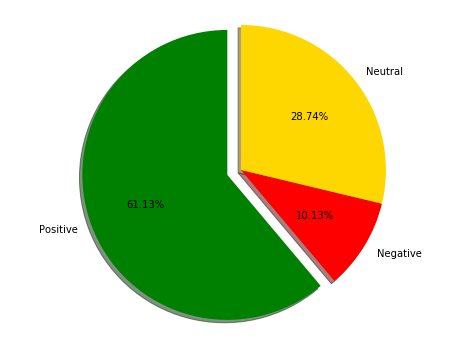

In [11]:
plt.rcParams["figure.figsize"] = [8, 6]
labels = ['Positive', 'Negative', 'Neutral']
sizes = [len(tweets_pos)/len(tweets_df), len(tweets_neg)/len(tweets_df), len(tweets_neu)/len(tweets_df)]
colors = ['green', 'red', 'gold']
explode = (0.1, 0, 0)
plt.pie(sizes, explode, labels, colors, autopct = '%1.2f%%', shadow = True, startangle = 90)
plt.axis('equal')
plt.show()

Get Document Term Matrix by CountVectorizer

In [12]:
countVec = CountVectorizer(min_df = 1)

In [13]:
dtm = countVec.fit_transform(tweets_df.text_clean)

In [14]:
words = countVec.get_feature_names()
freqs = dtm.sum(axis = 0).A1

In [15]:
wordFreq = list(zip(words, freqs))
print(len(wordFreq), freqs.sum())

8668 70971


Create Word Cloud

In [16]:
movieWords = ['kingsman', 'golden', 'circle', 'secret', 'service']
filterWords = ['see', 'seeing', 'saw', 'seen', 'watch', 'watching', 'watched', 'movie', 'movies', 'film', 'films']

text_pos = []
for tweet in tweets_pos['text_clean']:
    text_pos.extend([w for w in tweet.split() if w not in movieWords + filterWords])
    
text_neg = []
for tweet in tweets_neg['text_clean']:
    text_neg.extend([w for w in tweet.split() if w not in movieWords + filterWords])


In [17]:
wc = wordcloud.WordCloud(background_color = 'white', max_font_size= 100, random_state= 30)

In [26]:
Counter(text_pos).most_common(20)

[('good', 809),
 ('new', 472),
 ('first', 467),
 ('one', 357),
 ('free', 305),
 ('fun', 268),
 ('great', 262),
 ('review', 249),
 ('love', 247),
 ('video', 232),
 ('action', 224),
 ('really', 211),
 ('loved', 209),
 ('amazing', 208),
 ('best', 207),
 ('amp', 198),
 ('like', 190),
 ('better', 184),
 ('liked', 179),
 ('go', 178)]

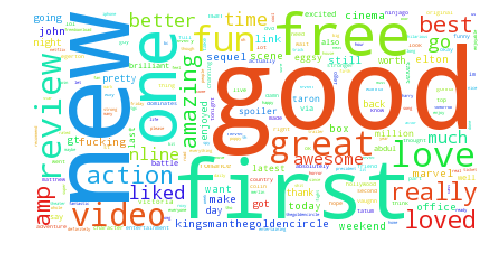

In [19]:
plt.imshow(wc.generate(' '.join(text_pos)))
plt.axis("off")
plt.show()

In [27]:
Counter(text_neg).most_common(20)

[('bad', 80),
 ('fucking', 71),
 ('fuck', 61),
 ('new', 53),
 ('one', 43),
 ('like', 41),
 ('amp', 38),
 ('hate', 38),
 ('expected', 34),
 ('less', 34),
 ('go', 34),
 ('still', 33),
 ('shit', 33),
 ('tatum', 32),
 ('channing', 32),
 ('really', 30),
 ('im', 29),
 ('sick', 29),
 ('sequel', 29),
 ('going', 29)]

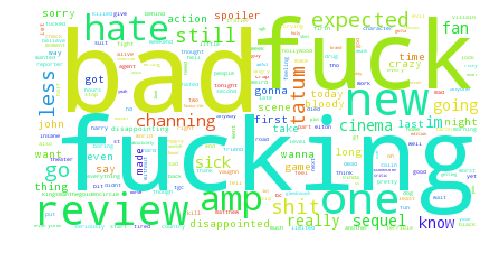

In [21]:
plt.figure(figsize = (8, 6))
plt.imshow(wc.generate(' '.join(text_neg)))
plt.axis("off")
plt.show()

Broad NRC Sentiment

In [22]:
nrcEmotionList = defaultdict(list)
nrc_file = "NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt"

with open(nrc_file, "r", encoding = "utf-8") as fr:
    for line in fr.readlines():
        word, emotion, value = line.replace("\n", "").split("\t")
        if int(value) == 1:
            nrcEmotionList[word].append(emotion)

In [23]:
def get_nrc_sentiment(text):
    emoCount = Counter()
    for word in text.split():
        if word in nrcEmotionList:
            emoCount += Counter(nrcEmotionList[word])
    return emoCount

In [24]:
emotion_df = pd.DataFrame([get_nrc_sentiment(tweet) for tweet in tweets_df['text_clean']])
print(emotion_df.sum())

anger           1544.0
anticipation    4868.0
disgust         1342.0
fear            2341.0
joy             3131.0
negative        3051.0
positive        5505.0
sadness         1460.0
surprise        2054.0
trust           3302.0
dtype: float64


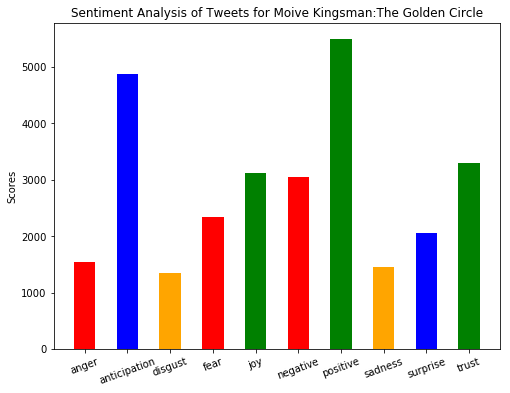

In [25]:
y = list(emotion_df.sum())
x = list(range(len(y)))
colors = ['red', 'blue', 'orange', 'red', 'green', 'red', 'green', 'orange', 'blue', 'green']
plt.bar(x, y, width = 0.5, color = colors)
plt.ylabel('Scores')
plt.xticks(x, (list(emotion_df.columns)), rotation = 20)
plt.title('Sentiment Analysis of Tweets for Moive Kingsman:The Golden Circle')
plt.show()